# HERA RFI Analysis



# Load Files

In [1]:
%matplotlib inline
from pyuvdata import UVData
import numpy as np
import itertools
import os

# load data here.

#items = os.listdir(".")
#str_dir = '/Users/josaitis/RFI_Analysis_7May/files/'
str_dir = '/lustre/aoc/projects/hera/ajosaiti/May7_cont/2458610/elev_actuator_on/'
items = os.listdir(str_dir)

uvfiles = []
for names in items:
    if names.endswith(".HH.uvh5"):
        uvfiles.append(names)
print('Files to process, in dir '+str_dir+': '+str(uvfiles))
uvfiles = [str_dir + s  for s in uvfiles]


uvd = UVData()
uvd.read_uvh5(uvfiles, axis='blt')

Files to process, in dir /lustre/aoc/projects/hera/ajosaiti/May7_cont/2458610/elev_actuator_on/: ['zen.2458611.04656.HH.uvh5', 'zen.2458611.04239.HH.uvh5', 'zen.2458611.04865.HH.uvh5', 'zen.2458611.04448.HH.uvh5', 'zen.2458611.05074.HH.uvh5', 'zen.2458611.03821.HH.uvh5', 'zen.2458611.03404.HH.uvh5', 'zen.2458611.03195.HH.uvh5', 'zen.2458611.03613.HH.uvh5', 'zen.2458611.05283.HH.uvh5', 'zen.2458611.04030.HH.uvh5']


In [2]:
# your answers here (hint: look at the attributes of your uvd object)

print 'There are', len(uvd.antenna_numbers), 'antennas and they are:', uvd.antenna_numbers

print 'There are', uvd.Nbls, 'baselines, which corresponds to N(N-1)/2 cross-correlations plus N auto-correlations.'

print 'There are', uvd.Nfreqs, 'frequencies, covering a range of', \
    np.min(uvd.freq_array)/1e6, 'MHz to',np.max(uvd.freq_array)/1e6,'MHz.'

print 'The width of each frequency channel is', (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e6, 'MHz'

print 'There are', uvd.Ntimes, 'time integrations.'

print 'The LSTs are', np.unique(uvd.lst_array)*12/np.pi, 'in hours.'

There are 11 antennas and they are: [ 0  1  2 11 12 13 23 24 25 26 39]
There are 66 baselines, which corresponds to N(N-1)/2 cross-correlations plus N auto-correlations.
There are 1536 frequencies, covering a range of 46.9207763671875 MHz to 234.2987060546875 MHz.
The width of each frequency channel is 0.12199083964029948 MHz
There are 231 time integrations.
The LSTs are [5.20009038 5.202483   5.20487563 5.20726825 5.20966088 5.21205351
 5.21444613 5.21683876 5.21923139 5.22162401 5.22401664 5.22640926
 5.22880189 5.23119452 5.23358714 5.23597977 5.23837239 5.24076502
 5.24315765 5.24555027 5.2479429  5.25033553 5.25272815 5.25512077
 5.25751339 5.25990602 5.26229865 5.26469127 5.2670839  5.26947652
 5.27186915 5.27426178 5.2766544  5.27904703 5.28143965 5.28383228
 5.28622491 5.28861753 5.29101016 5.29340279 5.29579541 5.29818804
 5.30058066 5.30297329 5.30536592 5.30775854 5.31015117 5.31254379
 5.31493642 5.31732905 5.31972167 5.3221143  5.32450693 5.32689955
 5.32929218 5.3316848  

# B) Visualizing Data and Flags

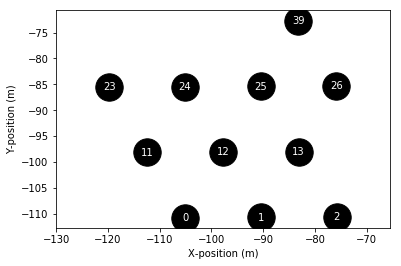

In [3]:
import matplotlib.pyplot as plt
#%matplotlib notebook

antpos, ants = uvd.get_ENU_antpos() # this returns coordinates of each antenna and a list of the antennas

plt.figure()
plt.scatter(antpos[:,0], antpos[:,1], marker='.', color='k', s=3000) # plot the antenna positions with black circles
for aa,ant in enumerate(ants): # loop over antennas
    plt.text(antpos[aa,0], antpos[aa,1], ants[aa], color='w', va='center', ha='center') # label antenna numbers
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.axis('equal');

# C) Pre-XRFI Waterfall Plots

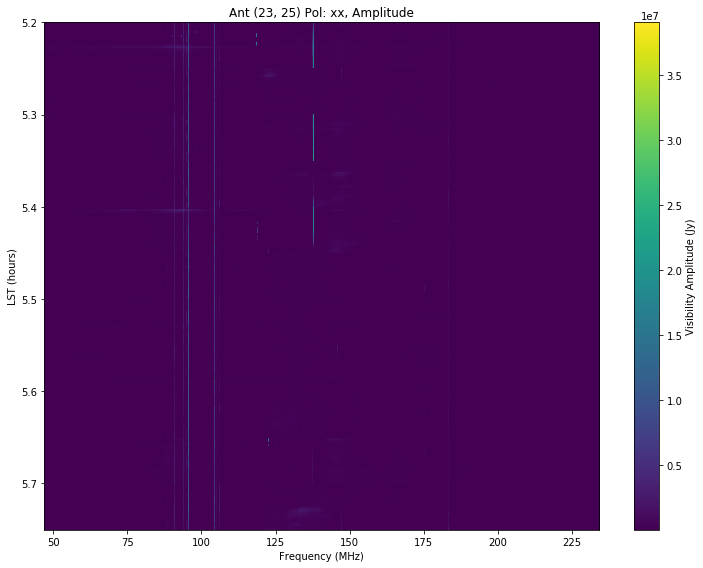

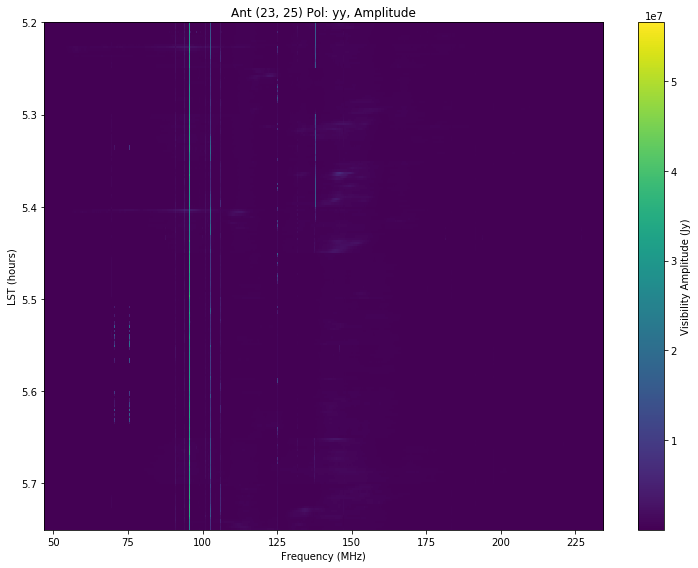

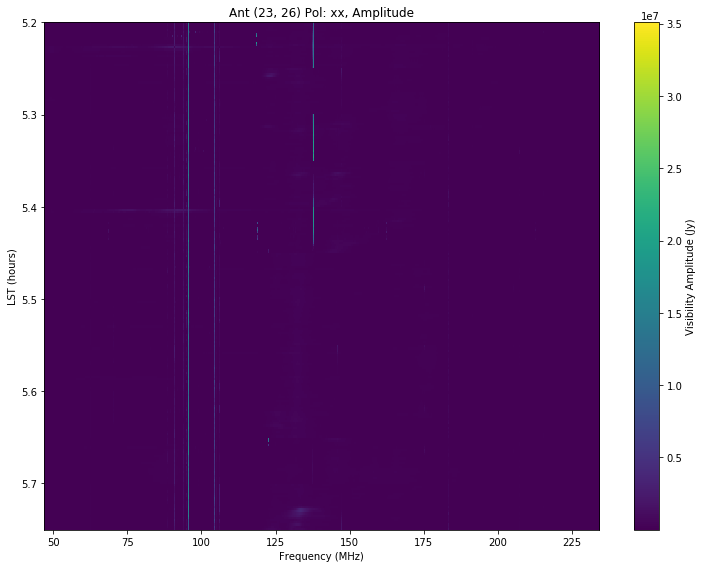

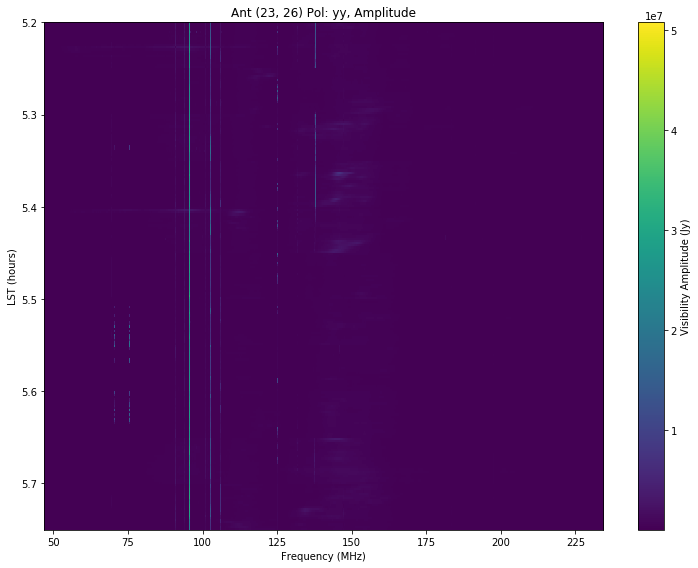

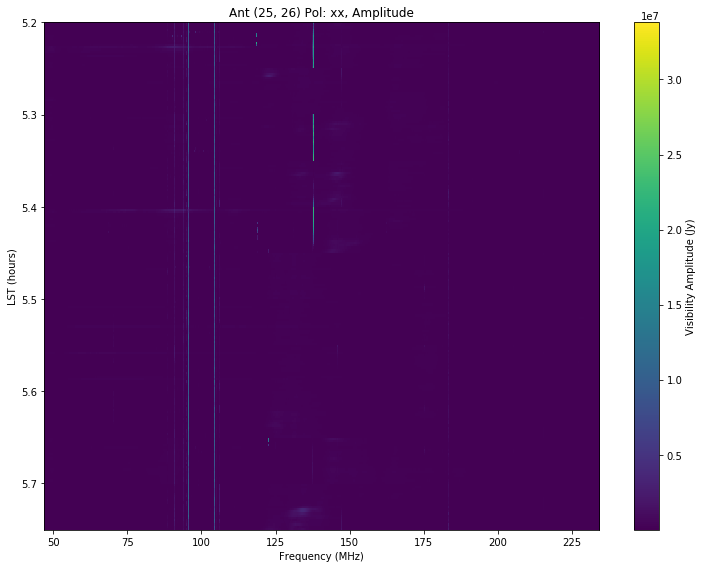

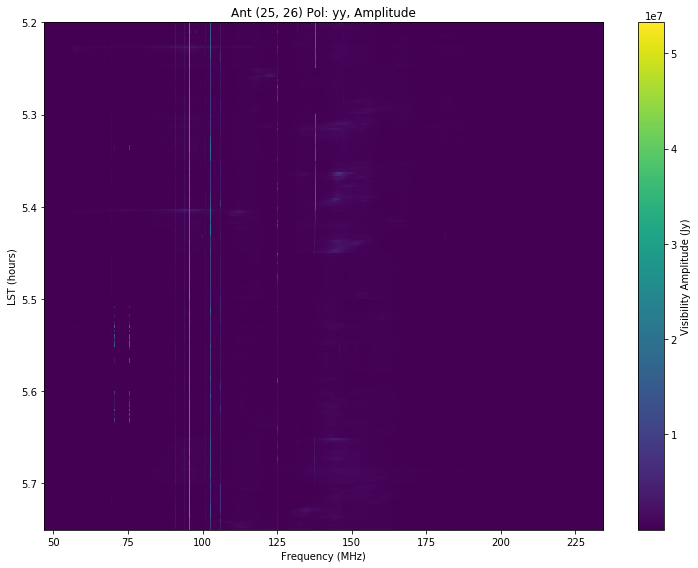

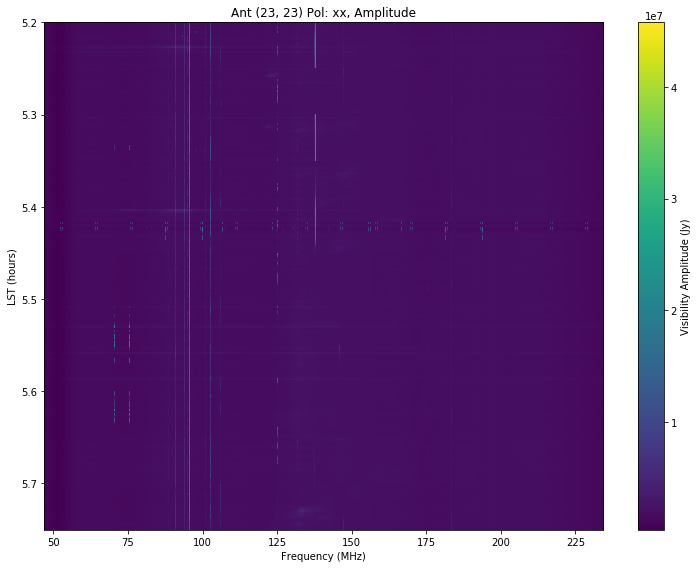

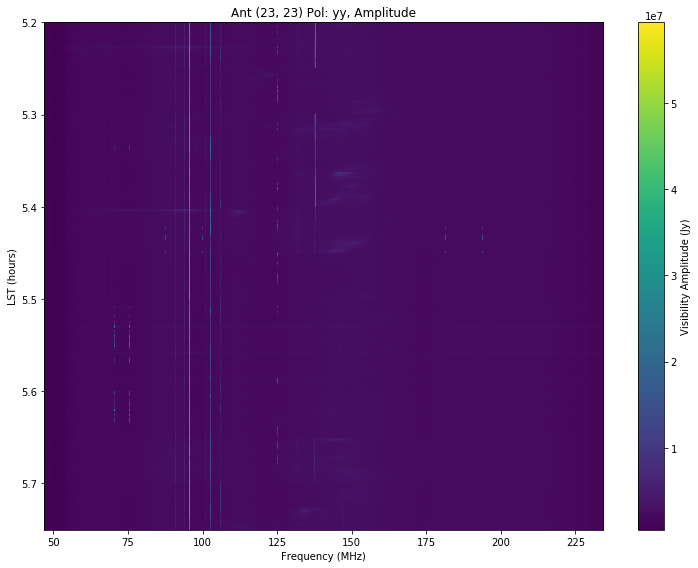

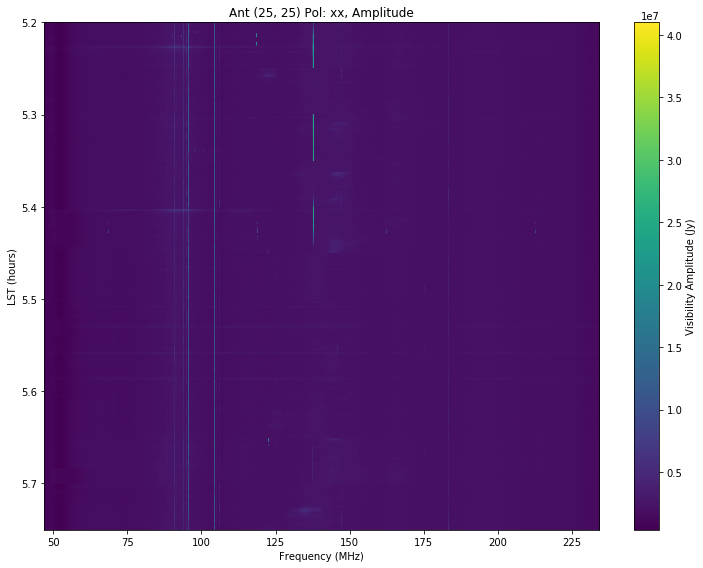

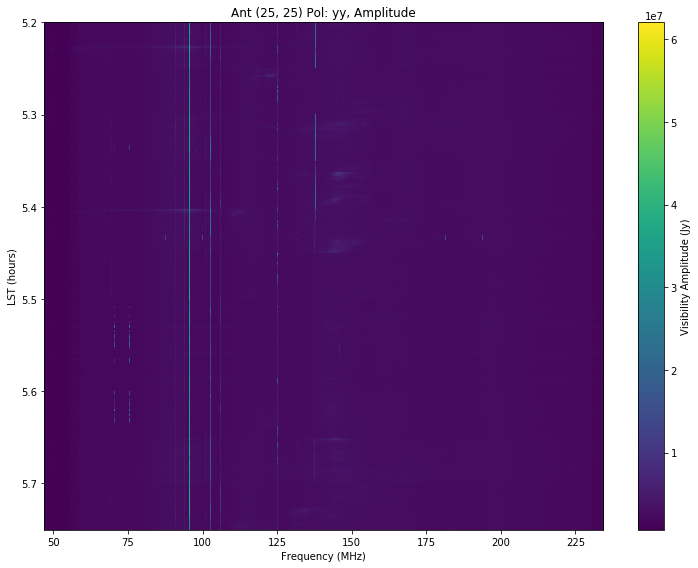

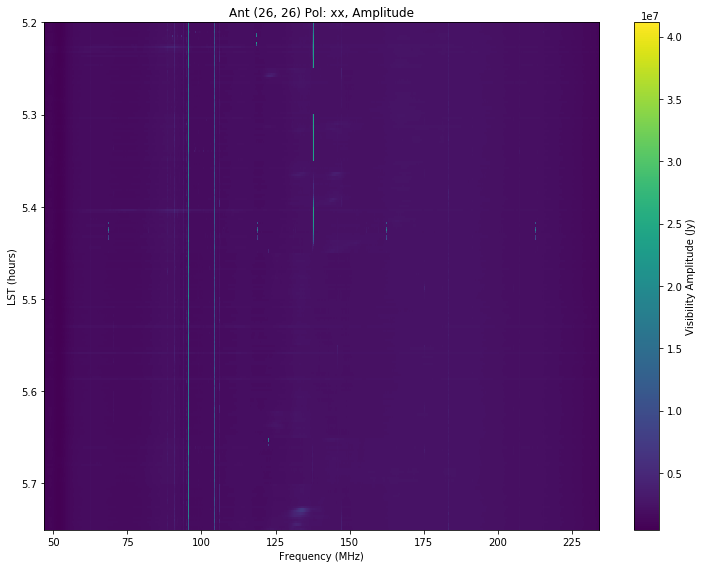

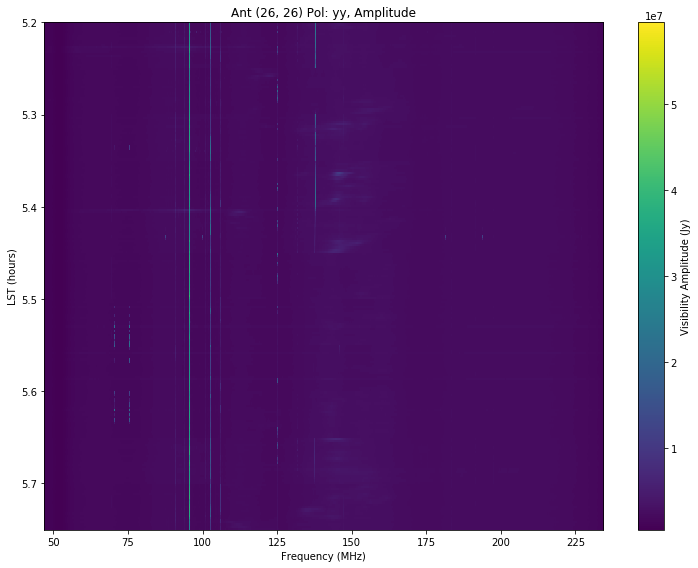

In [4]:
import matplotlib 

ants_select = np.array([23,25,26])
ant_combination = np.array( list( itertools.combinations(ants_select, 2) ) )
for ant in ants_select:
    ant_combination= np.append(ant_combination, [[ant,ant]], axis=0)
    
np.shape(ant_combination)

ii=0
while ii < np.size(ant_combination[:,0]):
    pols = np.array(['xx','yy'])
    for pol in pols:
        key=(ant_combination[ii,0],ant_combination[ii,1],str(pol))
        vis=uvd.get_data(key)
        plt.figure(figsize=(20,8))
        
        plt.subplot(121) #For amplitude
        plt.imshow(np.abs(vis), aspect='auto',extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.colorbar(label='Visibility Amplitude (Jy)')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.title('Ant ('+str(ant_combination[ii,0])+', '+str(ant_combination[ii,1])+') Pol: '+str(pol)+', Amplitude')

        plt.tight_layout();
    ii = ii+1


# Median and Mean Statistics, XRFI and Boxplot 

In [5]:
import xrfi_funcs
key=(26,26,'xx')
vis=uvd.get_data(key)
powers_per_time = np.abs(vis)
#calc XRFI-flagged visibility
XRFI_mask = xrfi_funcs.xrfi(powers_per_time)
powers_per_time_XRFI=np.ma.array(powers_per_time,mask=XRFI_mask)
total_power_chan_XRFI=10.0 * np.log10(np.sum(np.power(10.0, np.ma.masked_array(powers_per_time_XRFI).filled(np.ma.masked_array(powers_per_time_XRFI).mean()) / 10.0),0))

'''
x_boxplot=list(uvd.freq_array[0]/1.e6)
meanlineprops = dict(linestyle='--', linewidth=2.5, color='green')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
#plt.figure(1,figsize=(25,25))
#plt.boxplot(abs(vis),widths=0.05,meanprops=meanlineprops,showfliers=False,positions=x_boxplot,meanline=True,whis='range',patch_artist=True,manage_xticks=False)

#plt.title('Boxplot (Pre XRFI): Median (Red), Mean (Green), 25/75th Percentiles, and Max/Min.')
#plt.xticks(rotation='vertical')
#plt.xticks(np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,50),rotation='vertical')
#ylim_min = 1.05*np.min(np.min(powers_per_time,axis=0))#ATJ
#ylim_max = 0.95*np.max(np.max(powers_per_time,axis=0)) #ATJ
#plt.ylim([ylim_min,ylim_max])#ATJ

plt.figure(1,figsize=(25,25))
pwr_xrfi_vec_seq = [[y for y in row if y] for row in powers_per_time_XRFI.T]
plt.figure(1,figsize=(25,25))
plt.boxplot(pwr_xrfi_vec_seq,widths=0.05,meanprops=meanlineprops,showfliers=False,positions=x_boxplot,meanline=True,whis='range',patch_artist=True,manage_xticks=False)
plt.title('Boxplot (Post XRFI): Median (Red), Mean (Green), 25/75th Percentiles, and Max/Min.')
plt.xticks(np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,50),rotation='vertical')
#plt.ylim([ylim_min, ylim_max]) 

K = 8 #the box size for taking medians in xrfi, see xrfi_funcs.xrfi()
arr2D_pow = np.tile( np.max( np.ma.masked_array(powers_per_time_XRFI).filled(np.ma.masked_array(powers_per_time_XRFI).mean() ),axis=0) , (int(2.*K +2),1))
print('For XRFI algorithm: K = '+str(K)+', shape of xrfi input (arr2D_pow): '+str(np.shape(arr2D_pow)))
xrfi_mask = xrfi_funcs.xrfi( arr2D_pow, K=K )
masked_y = np.ma.masked_array( arr2D_pow[0,:][np.where(xrfi_mask[0,:])])
print('After running XRFI on the full data set, if I run a 1D XRFI on the max vals per channel, I get '+str(np.size(np.where(xrfi_mask[0,:])))+' channels that still could be RFI'  )

'''

divide by zero encountered in divide
overflow encountered in power


"\nx_boxplot=list(uvd.freq_array[0]/1.e6)\nmeanlineprops = dict(linestyle='--', linewidth=2.5, color='green')\nmedianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')\n#plt.figure(1,figsize=(25,25))\n#plt.boxplot(abs(vis),widths=0.05,meanprops=meanlineprops,showfliers=False,positions=x_boxplot,meanline=True,whis='range',patch_artist=True,manage_xticks=False)\n\n#plt.title('Boxplot (Pre XRFI): Median (Red), Mean (Green), 25/75th Percentiles, and Max/Min.')\n#plt.xticks(rotation='vertical')\n#plt.xticks(np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,50),rotation='vertical')\n#ylim_min = 1.05*np.min(np.min(powers_per_time,axis=0))#ATJ\n#ylim_max = 0.95*np.max(np.max(powers_per_time,axis=0)) #ATJ\n#plt.ylim([ylim_min,ylim_max])#ATJ\n\nplt.figure(1,figsize=(25,25))\npwr_xrfi_vec_seq = [[y for y in row if y] for row in powers_per_time_XRFI.T]\nplt.figure(1,figsize=(25,25))\nplt.boxplot(pwr_xrfi_vec_seq,widths=0.05,meanprops=meanlineprops,showfliers=False

# Neighboring channel analysis - Antenna 26, Pol XX

Post XRFI: detect low-level RFI. Try calculating ratio of median over all time (persistent RFI) and std over all time (for transient RFI) of neighboring channels. Which channels have the highest ratios? Also perform an integrated-overall-all-time, per channel comparison. 

divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in log
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in log
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in log
divide by zero encountered in divide
invalid value encountered in divide


([<matplotlib.axis.XTick at 0x7faf91e34ed0>,
 <a list of 50 Text xticklabel objects>)

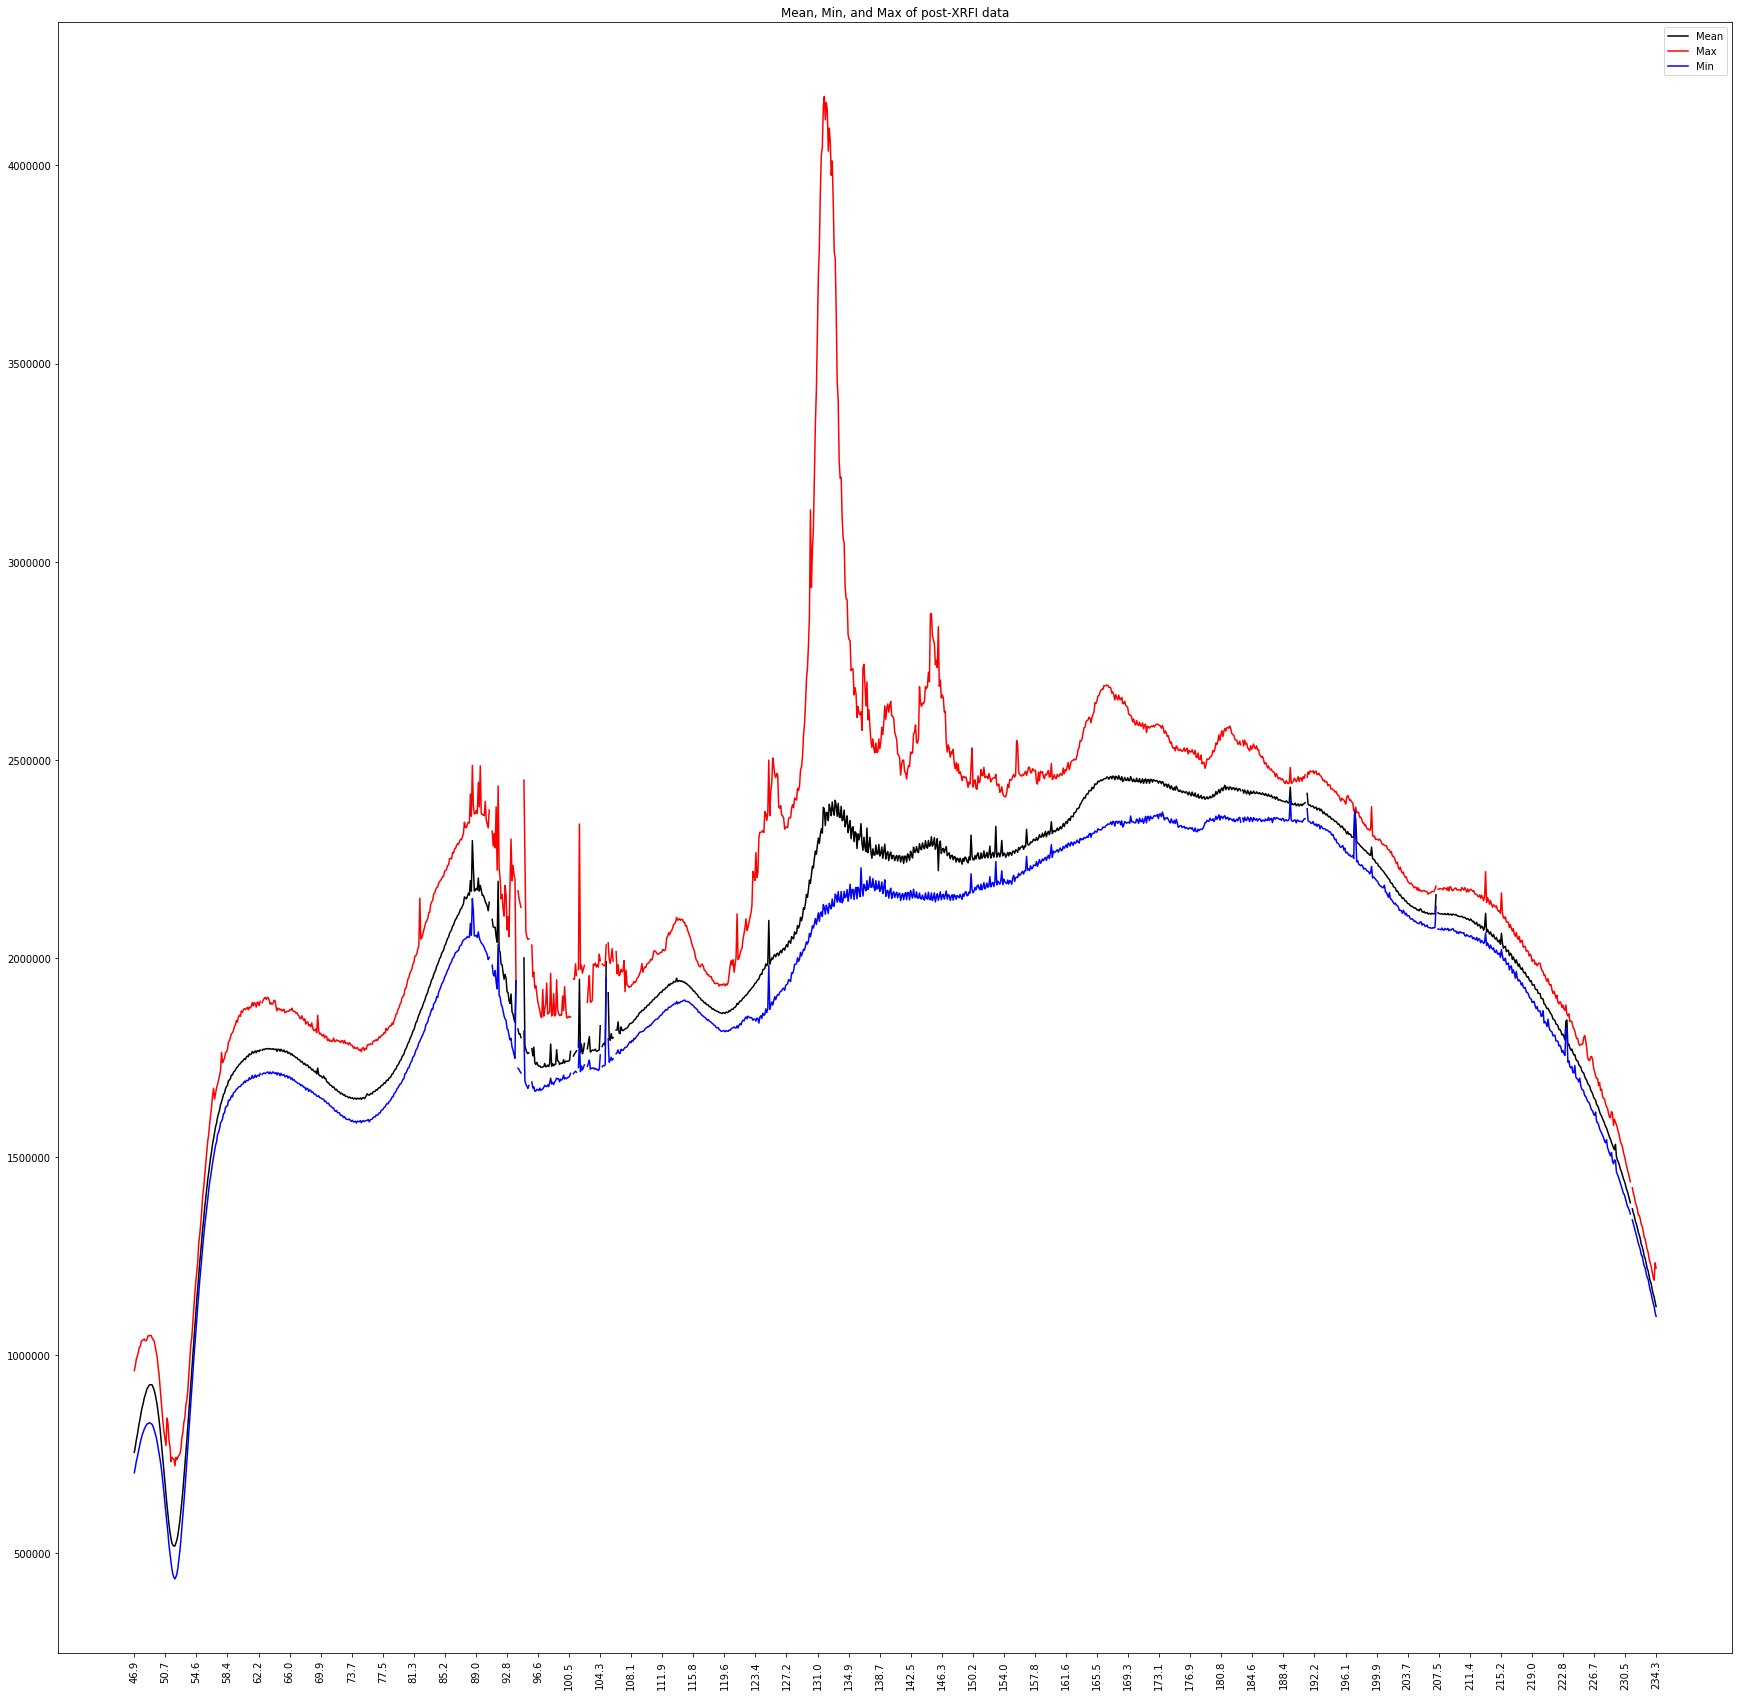

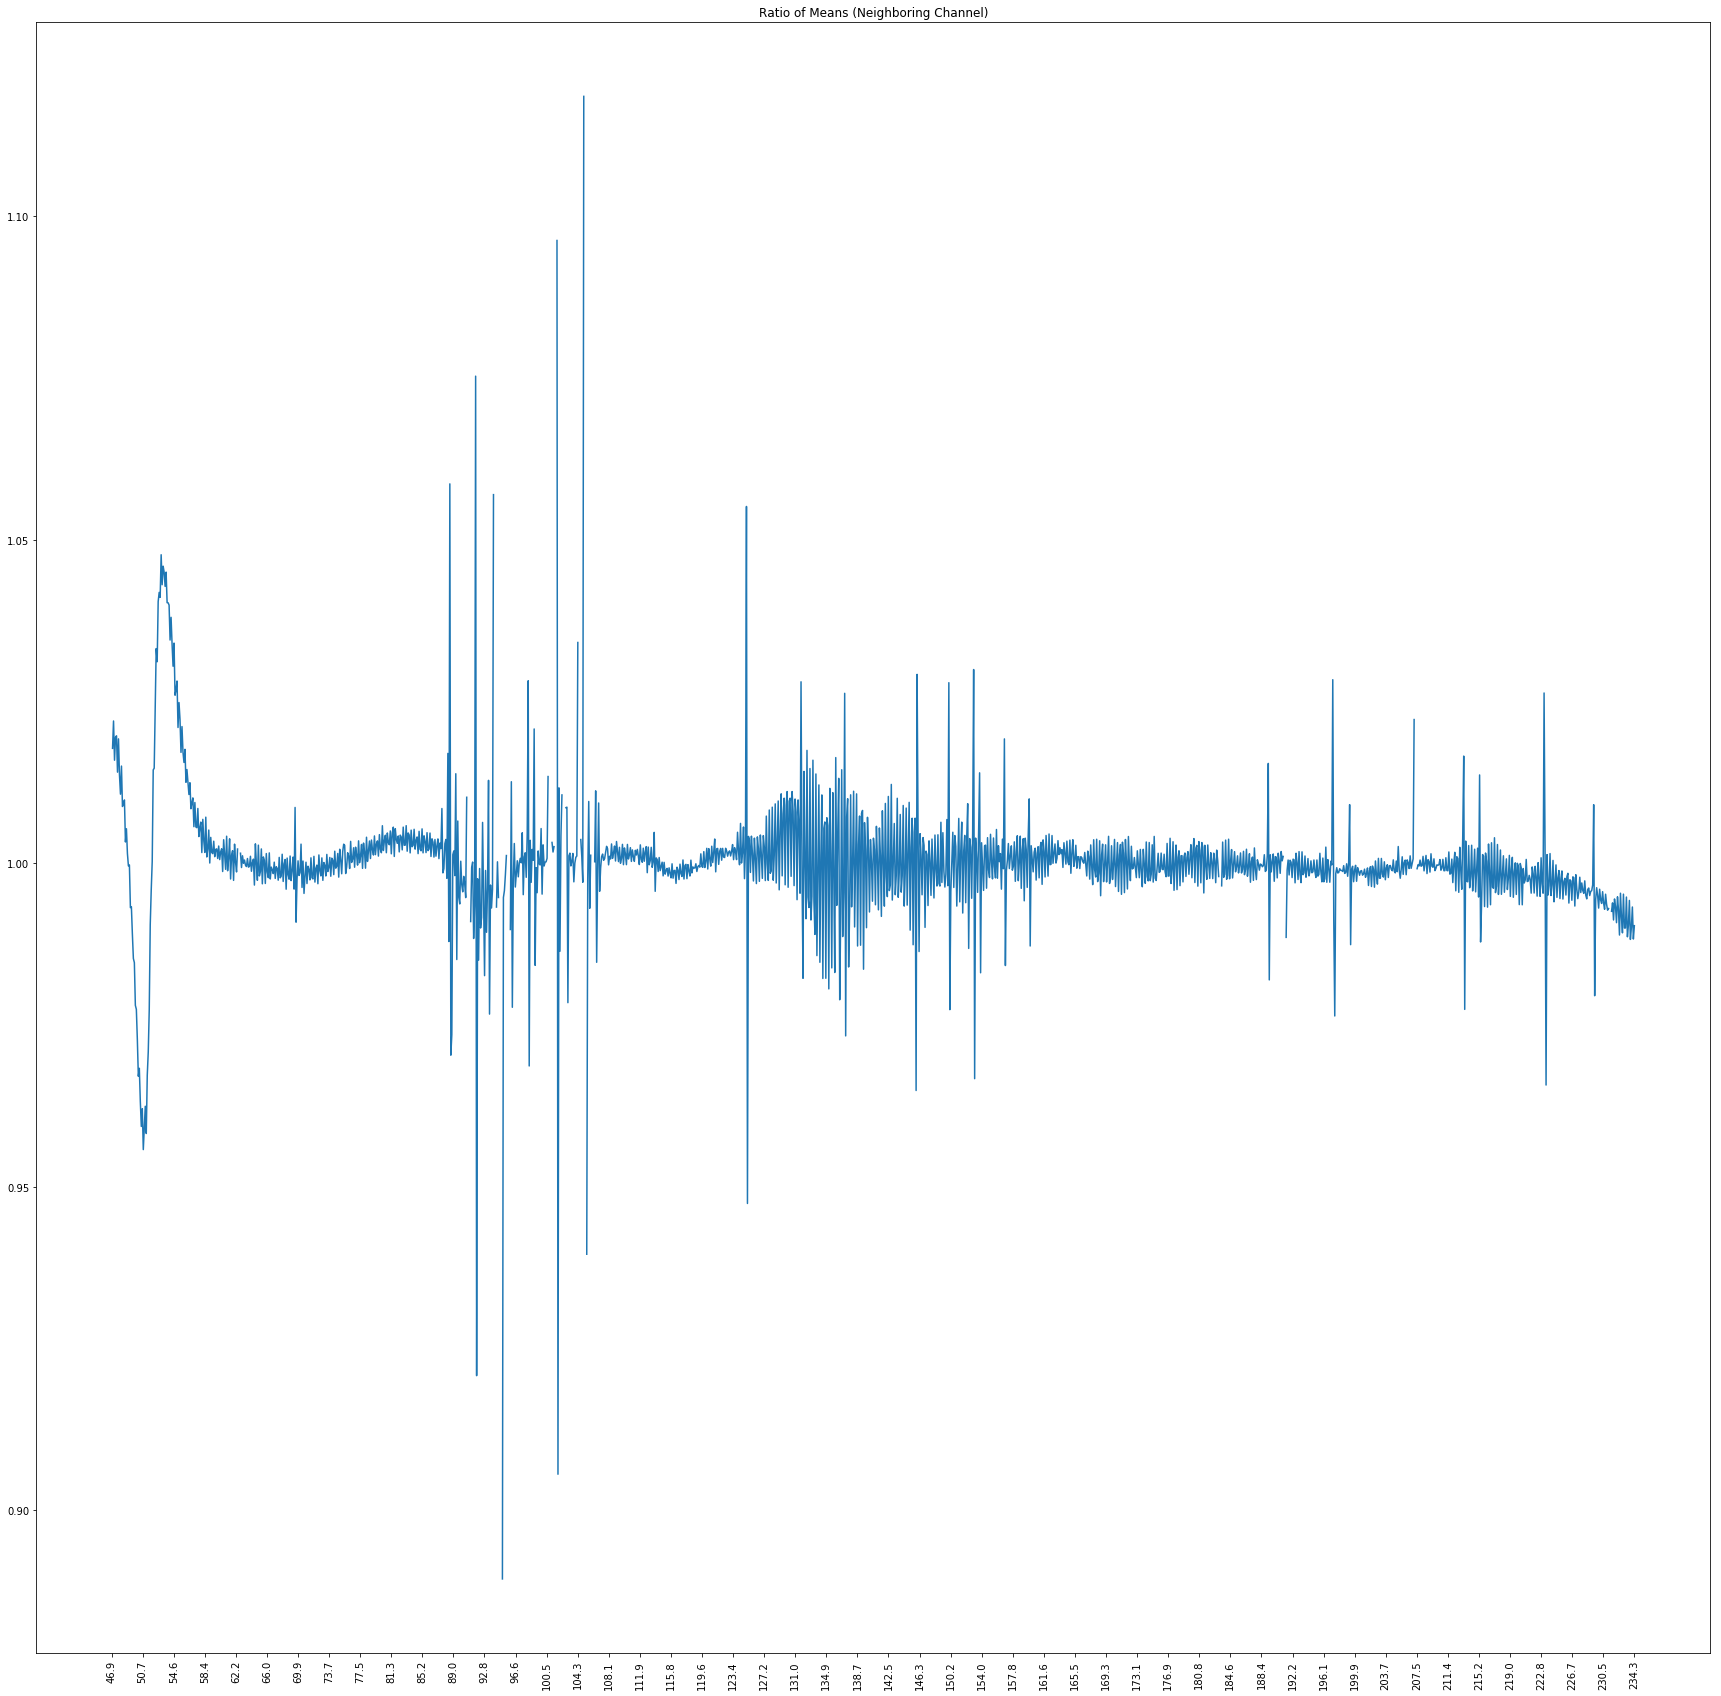

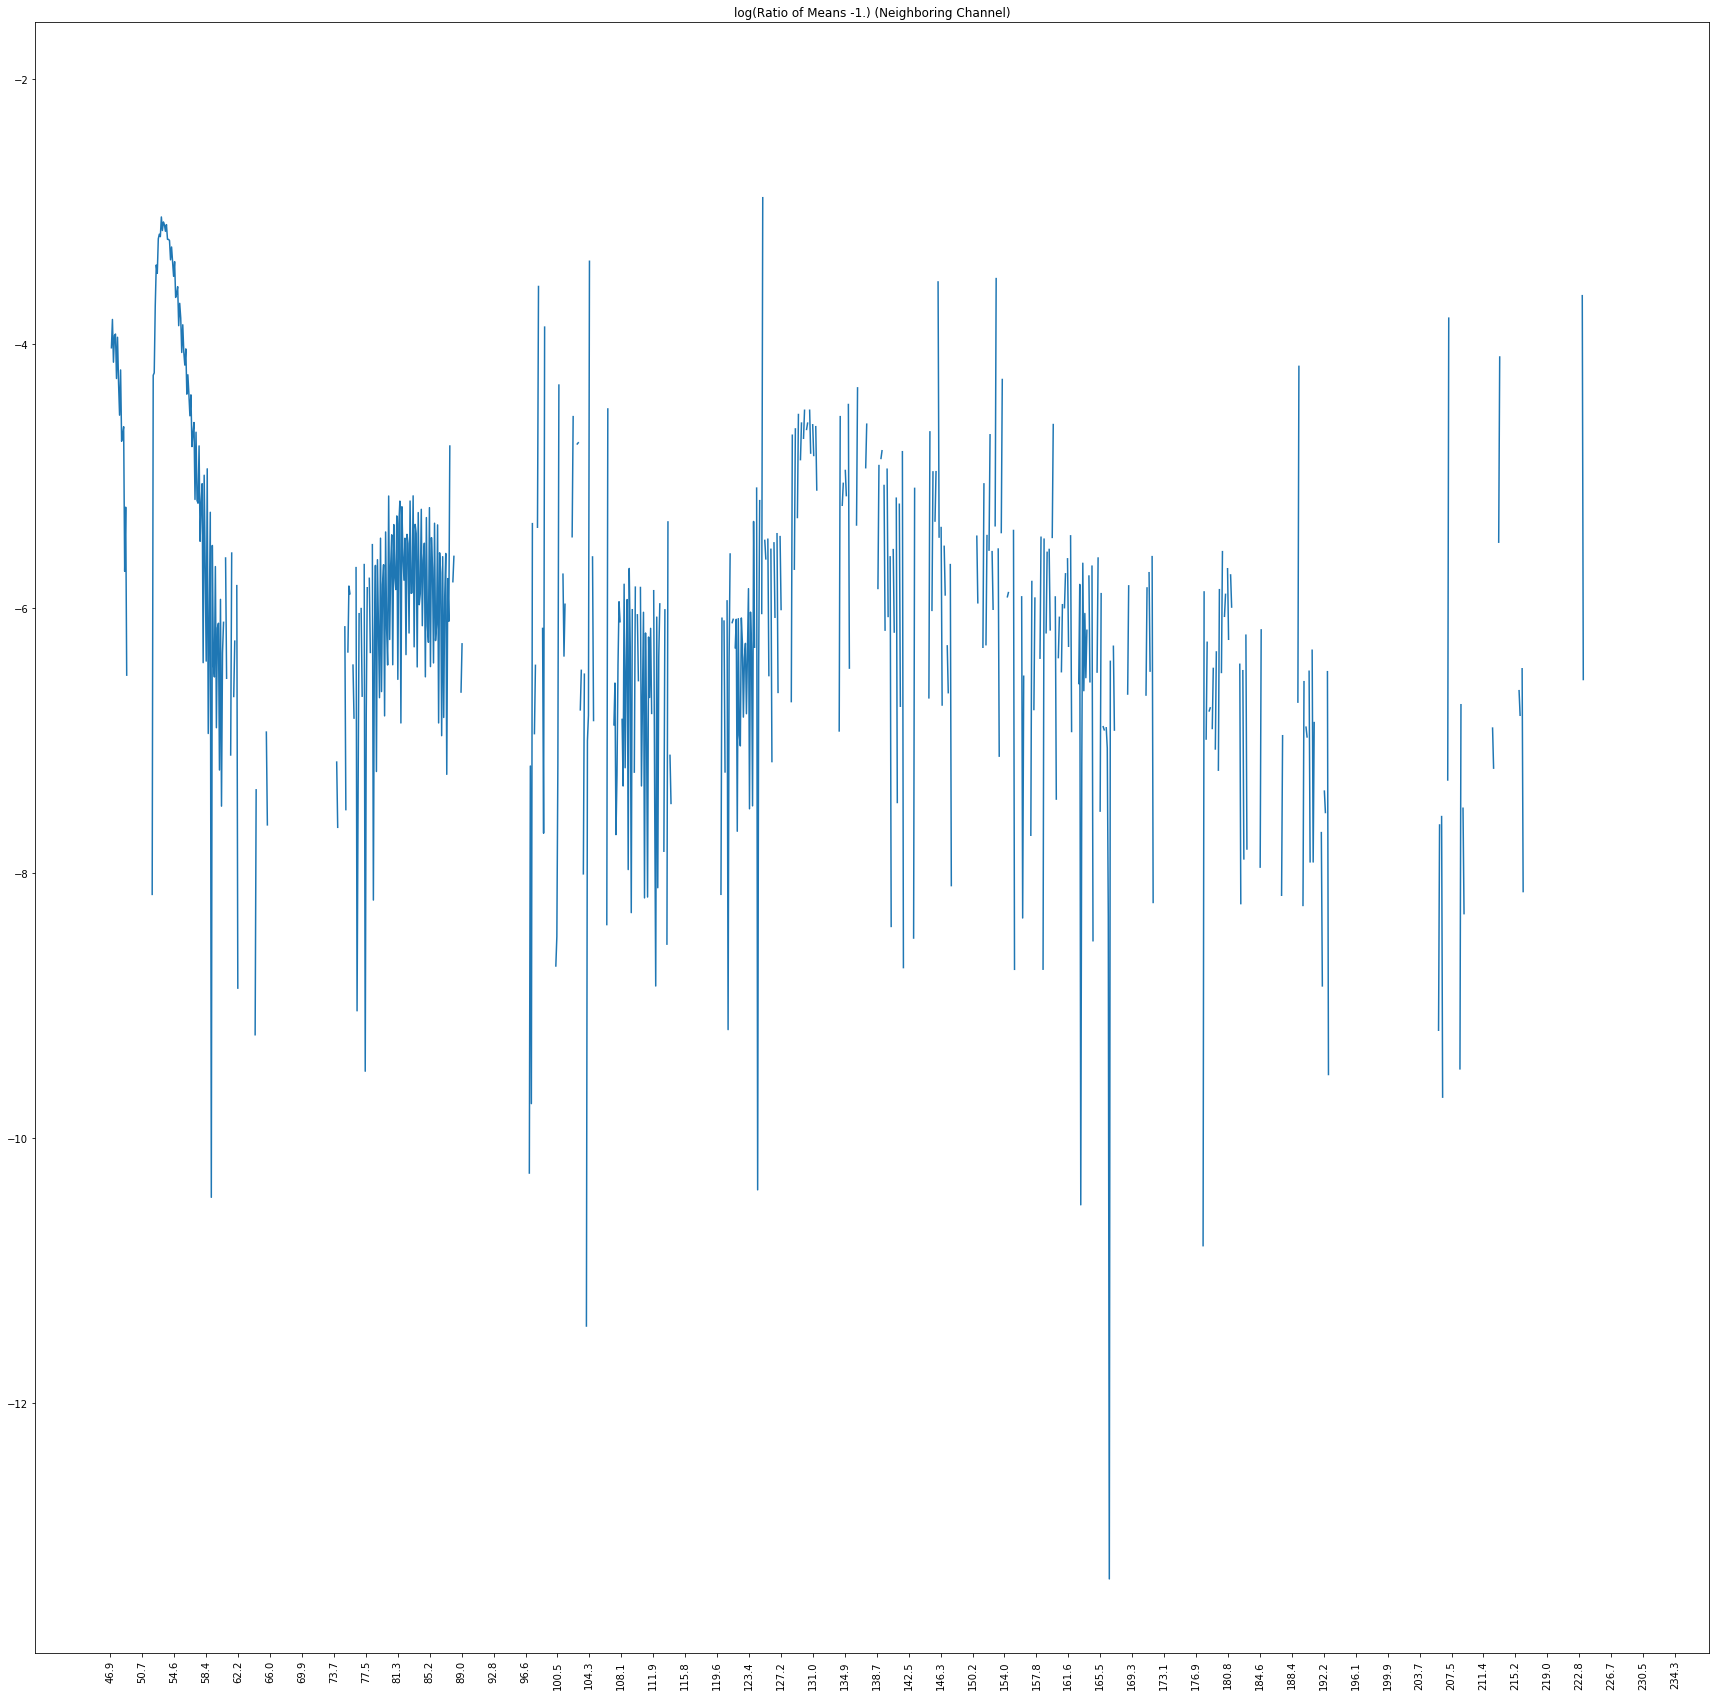

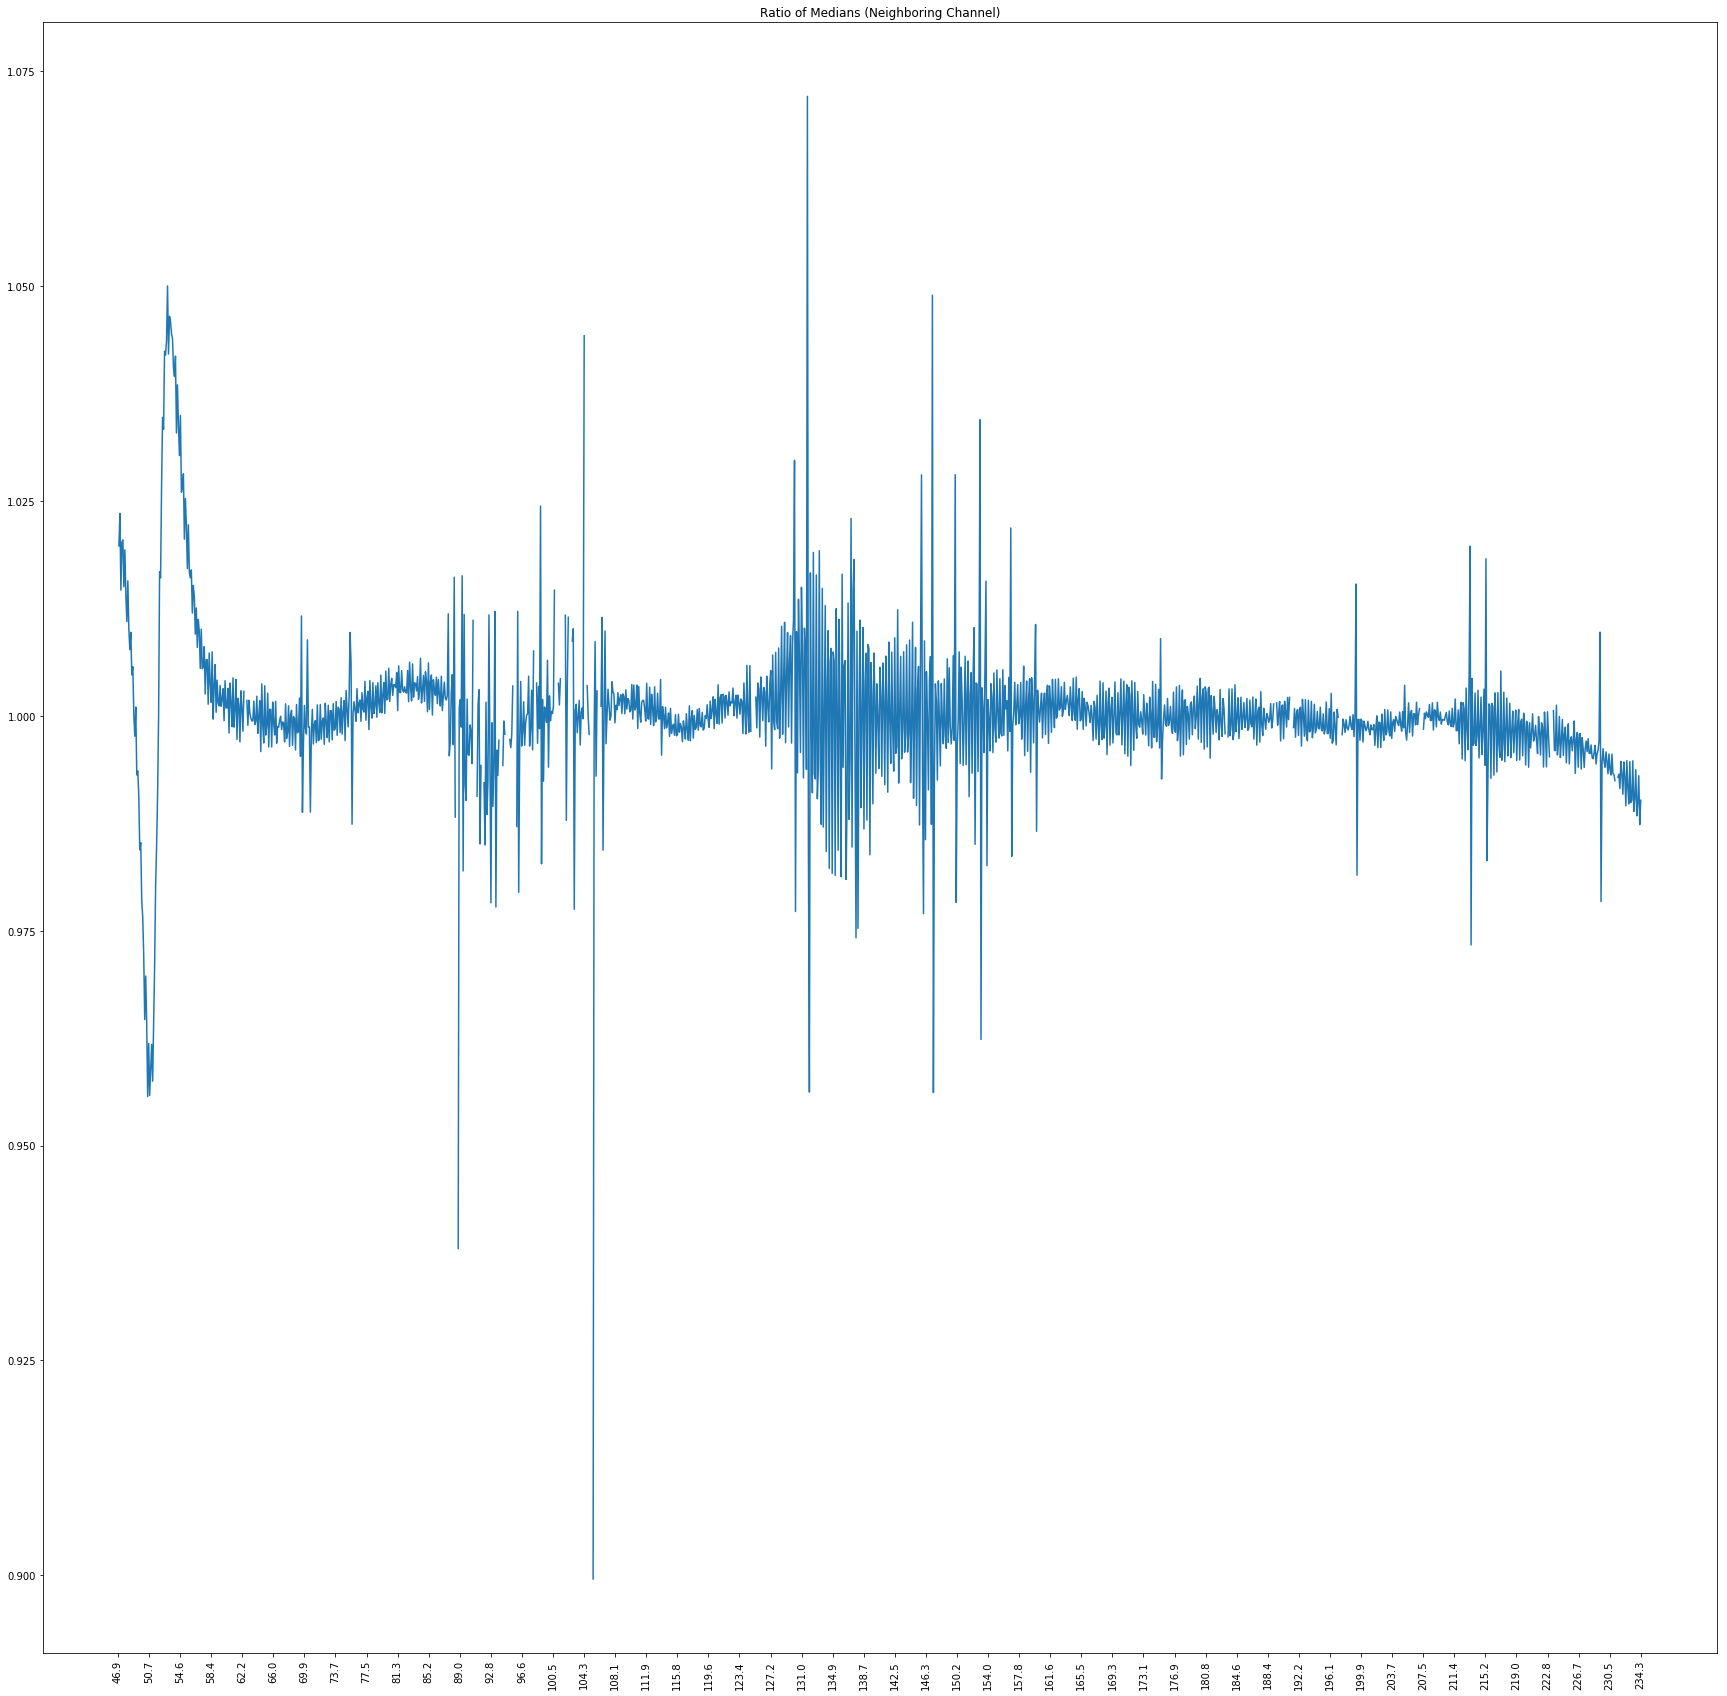

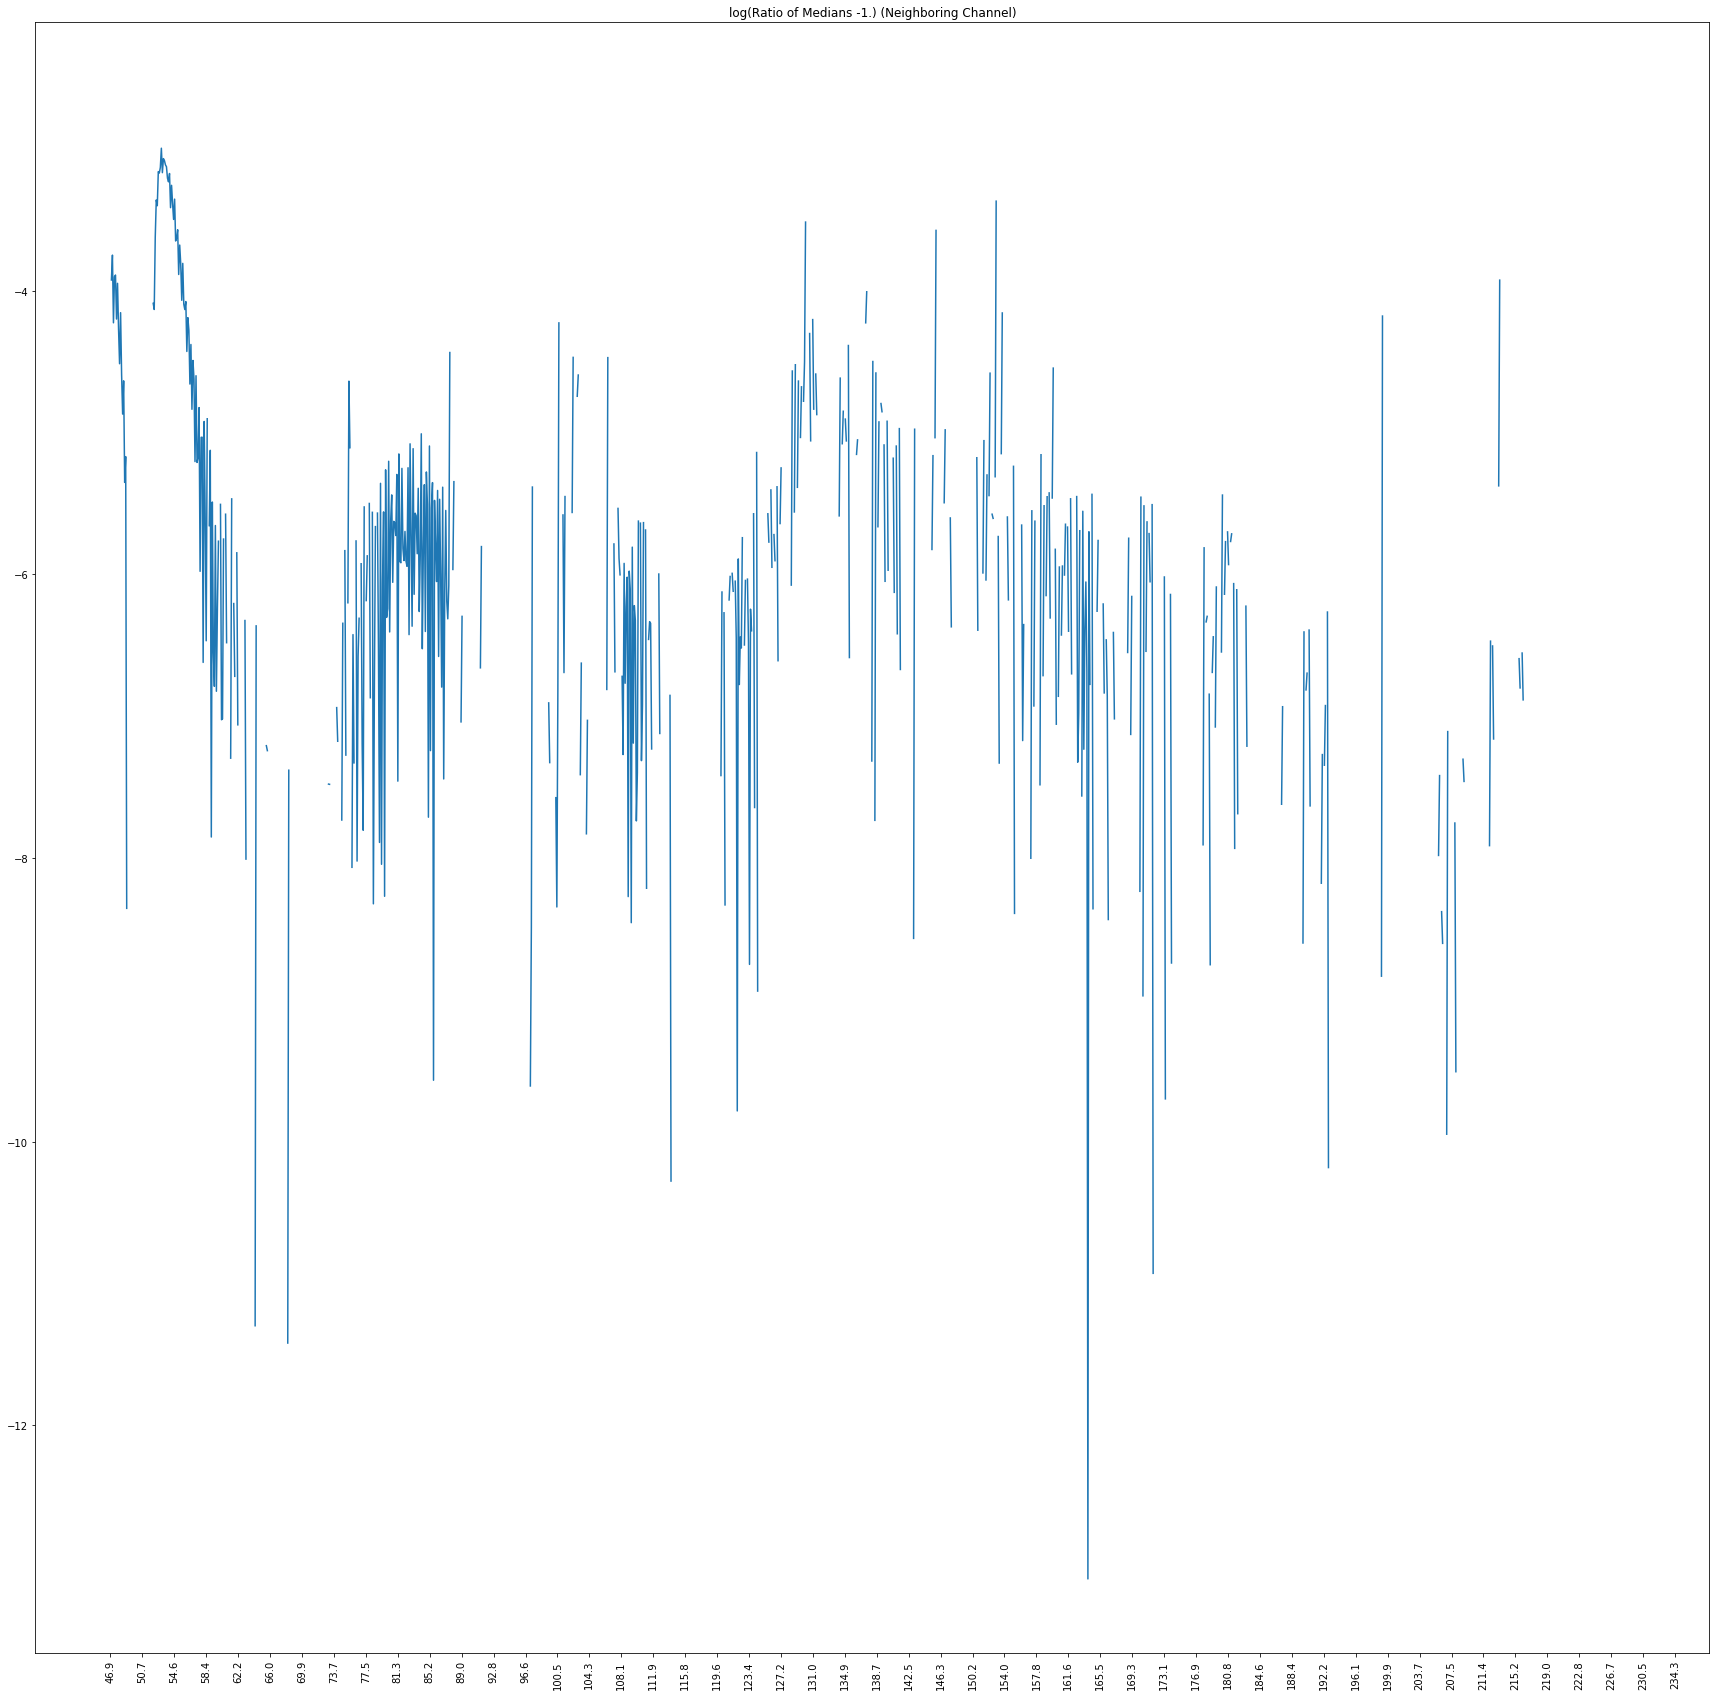

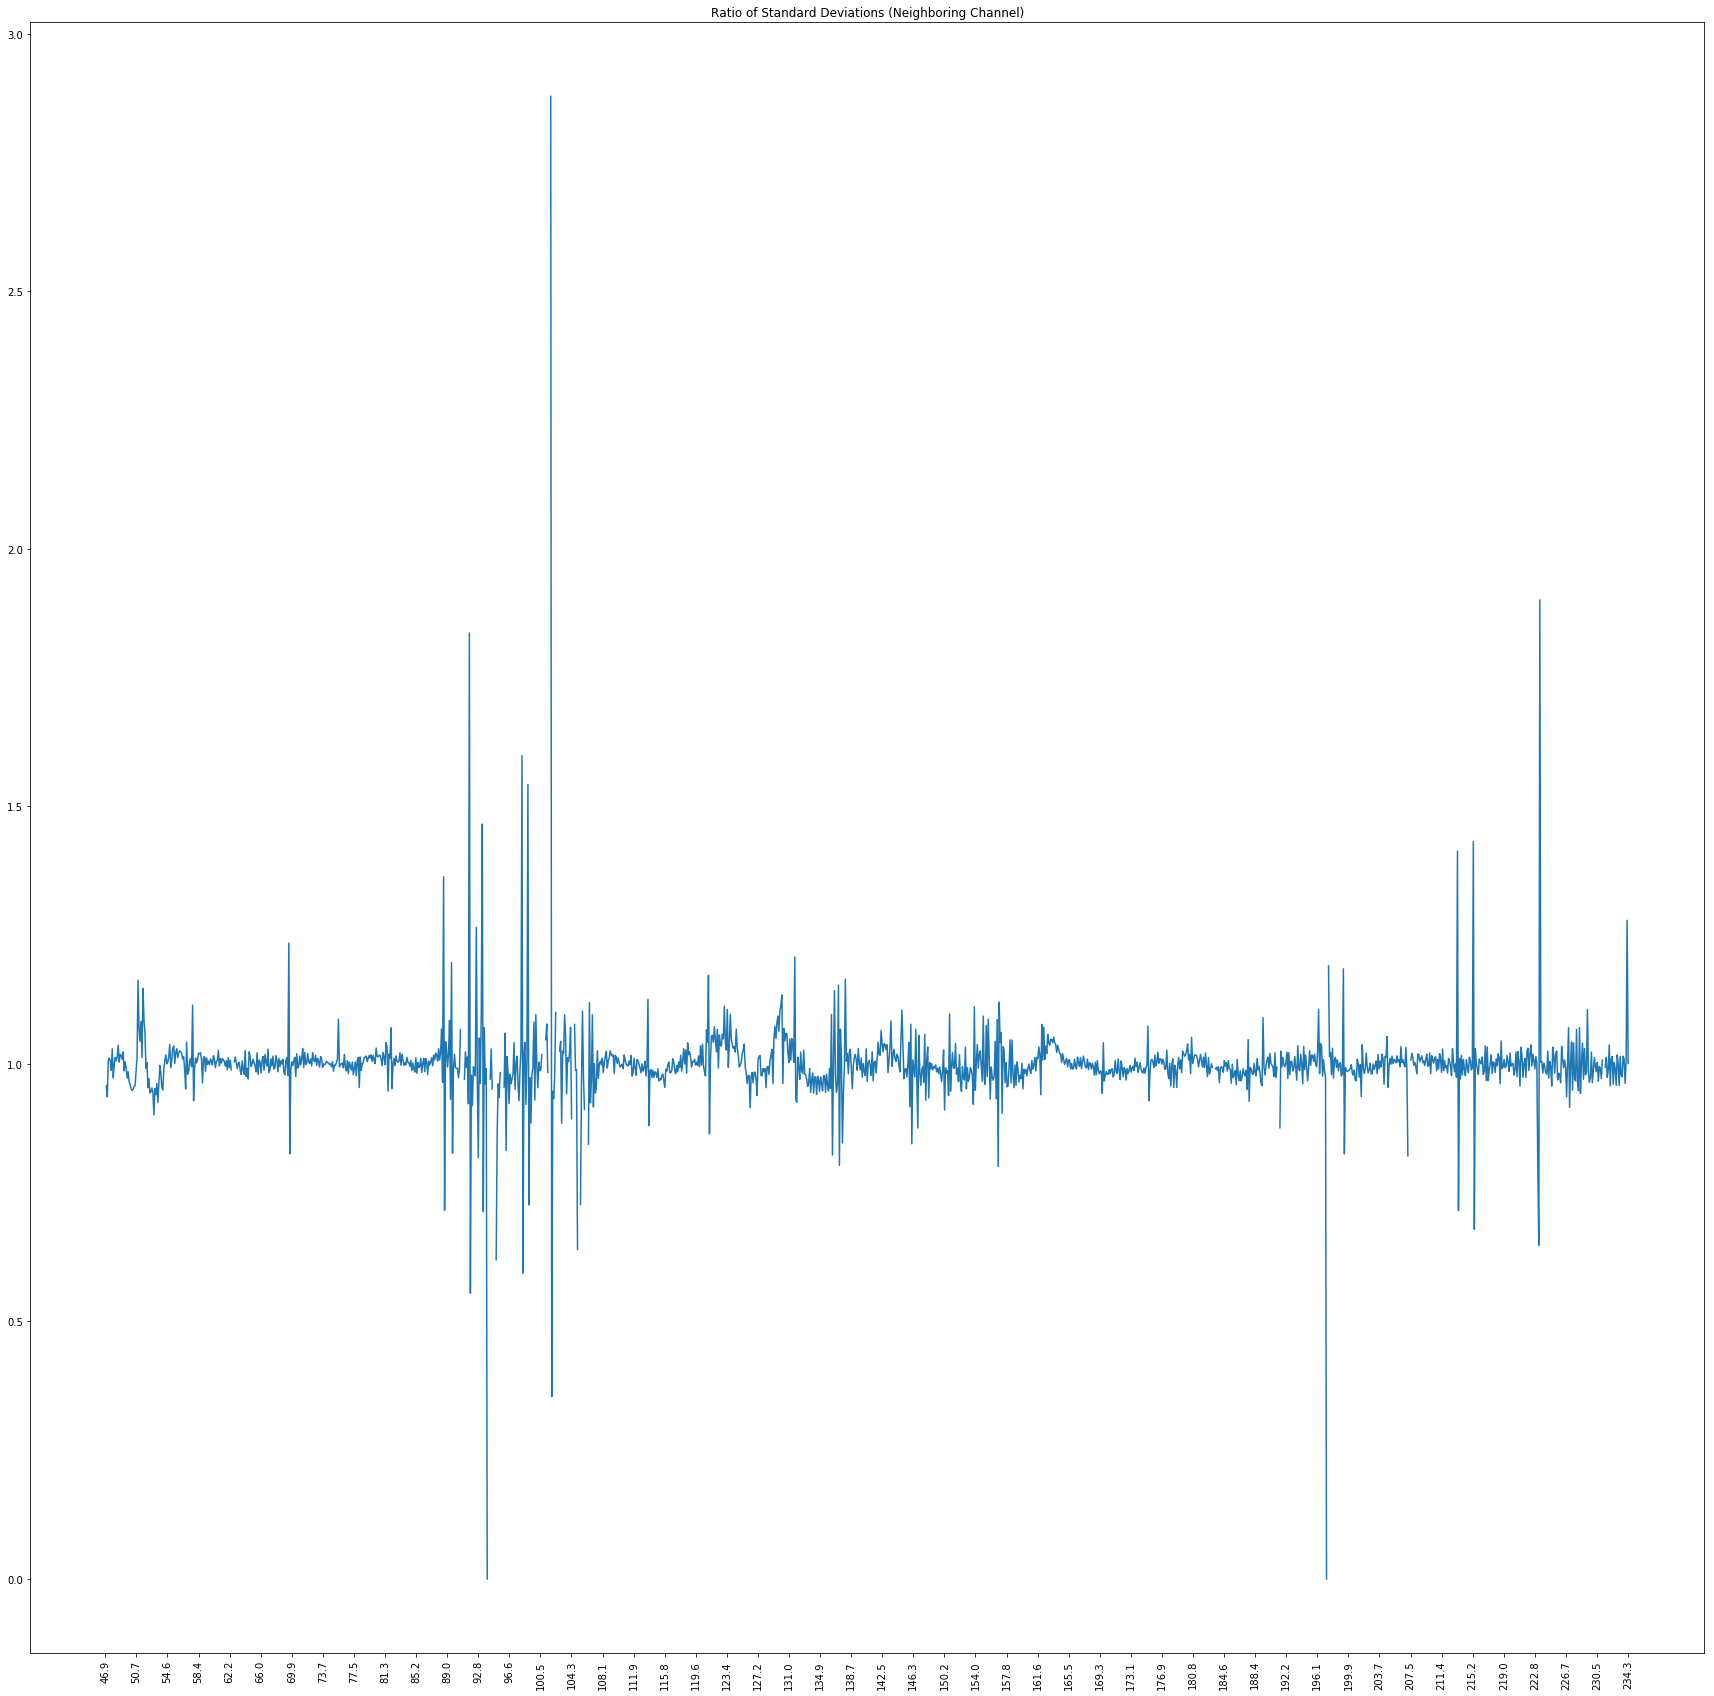

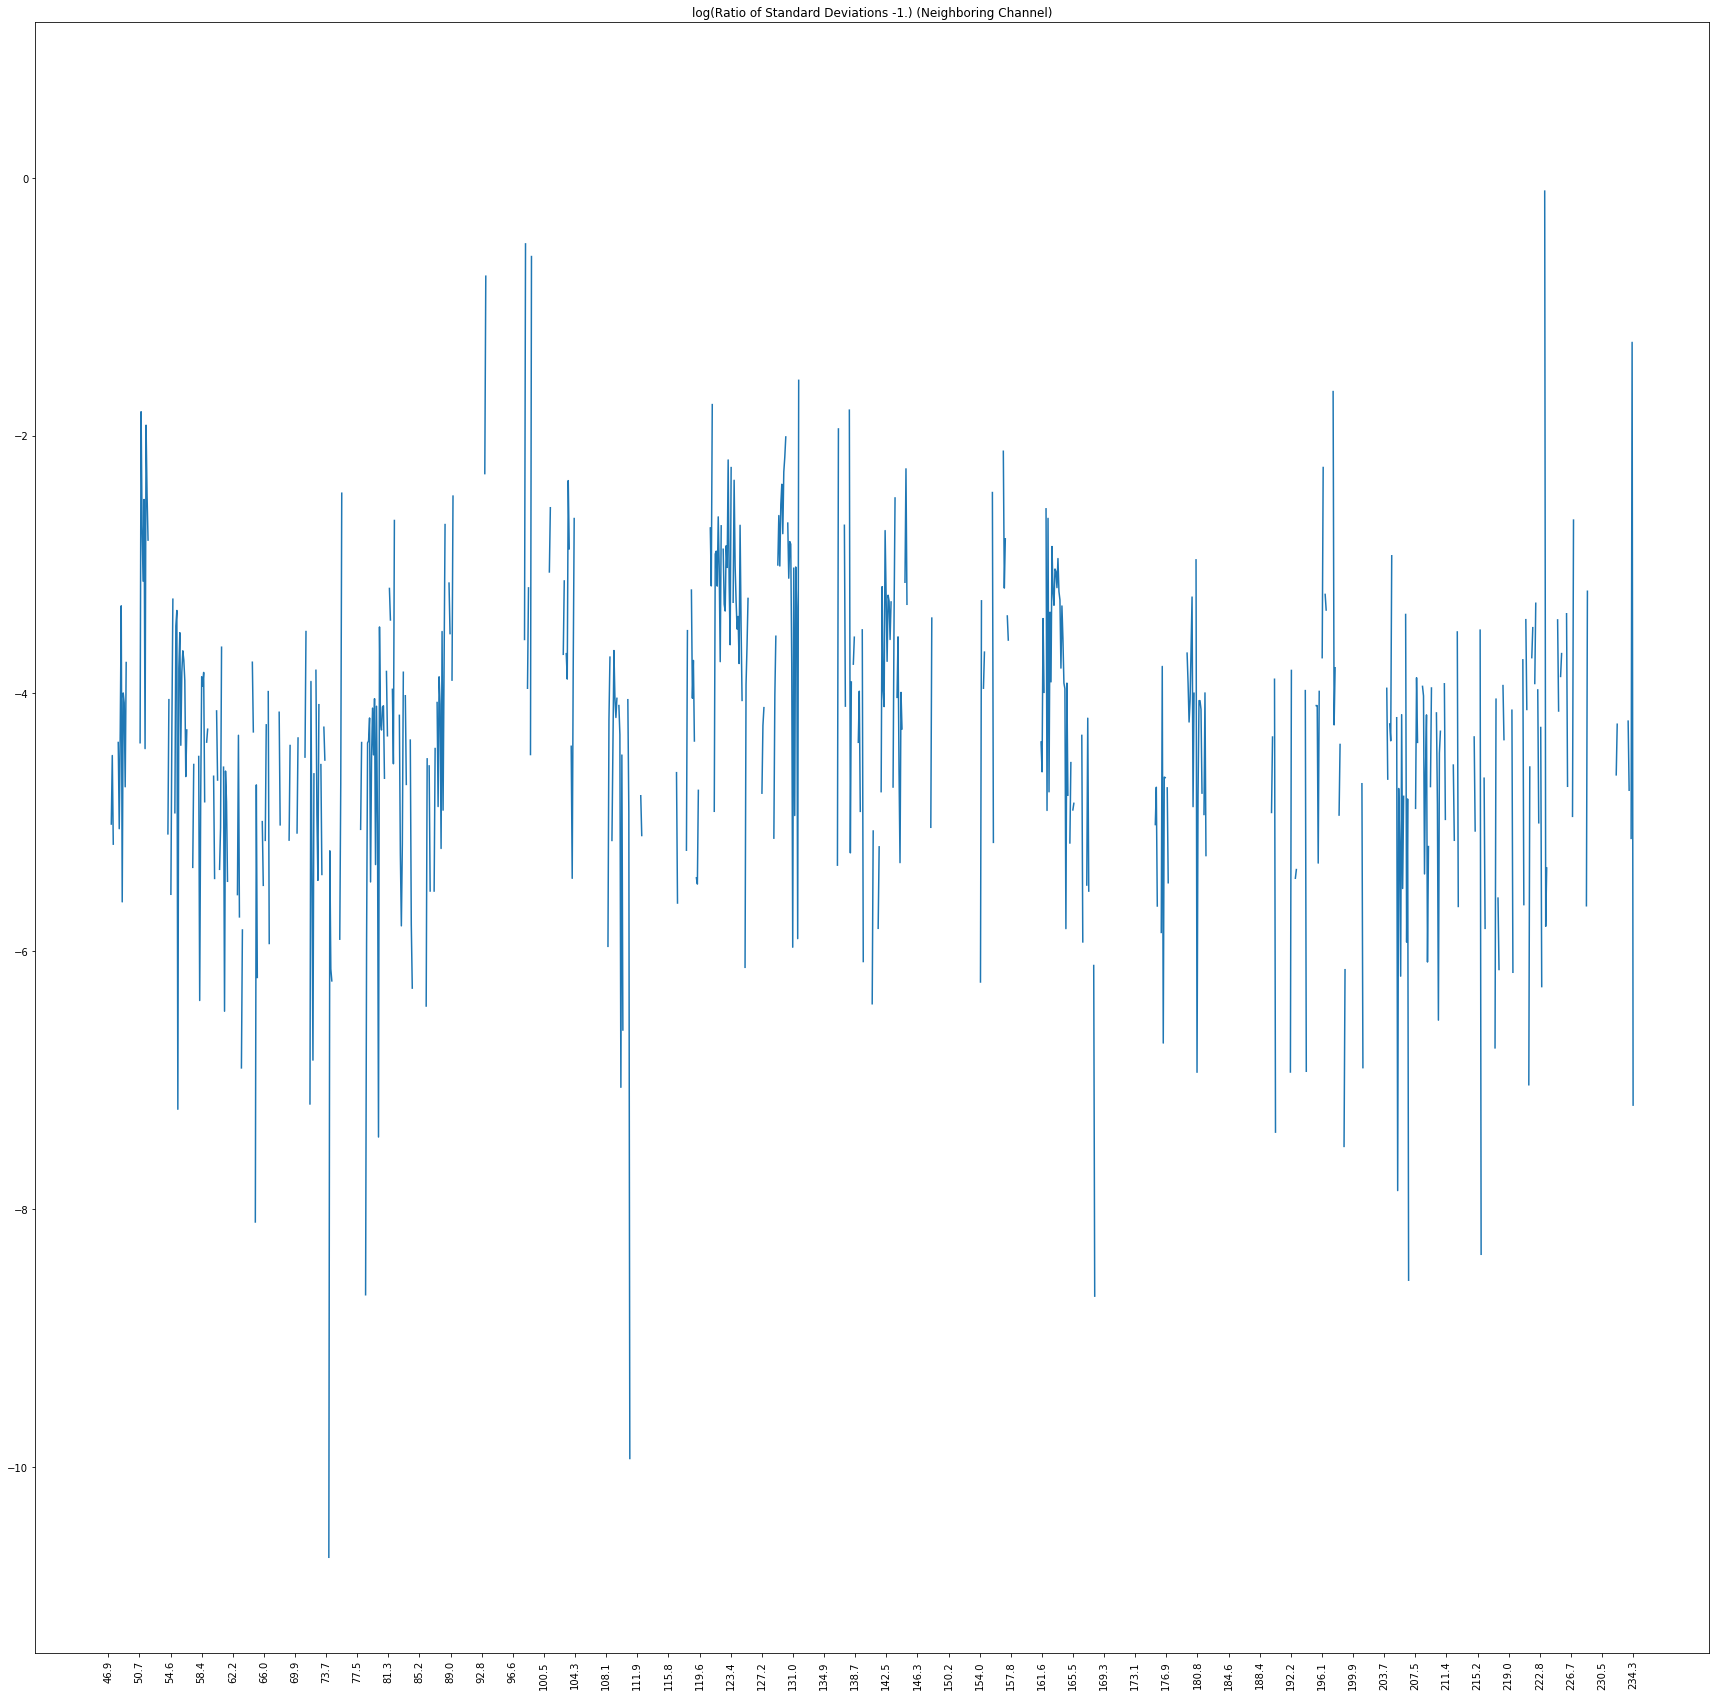

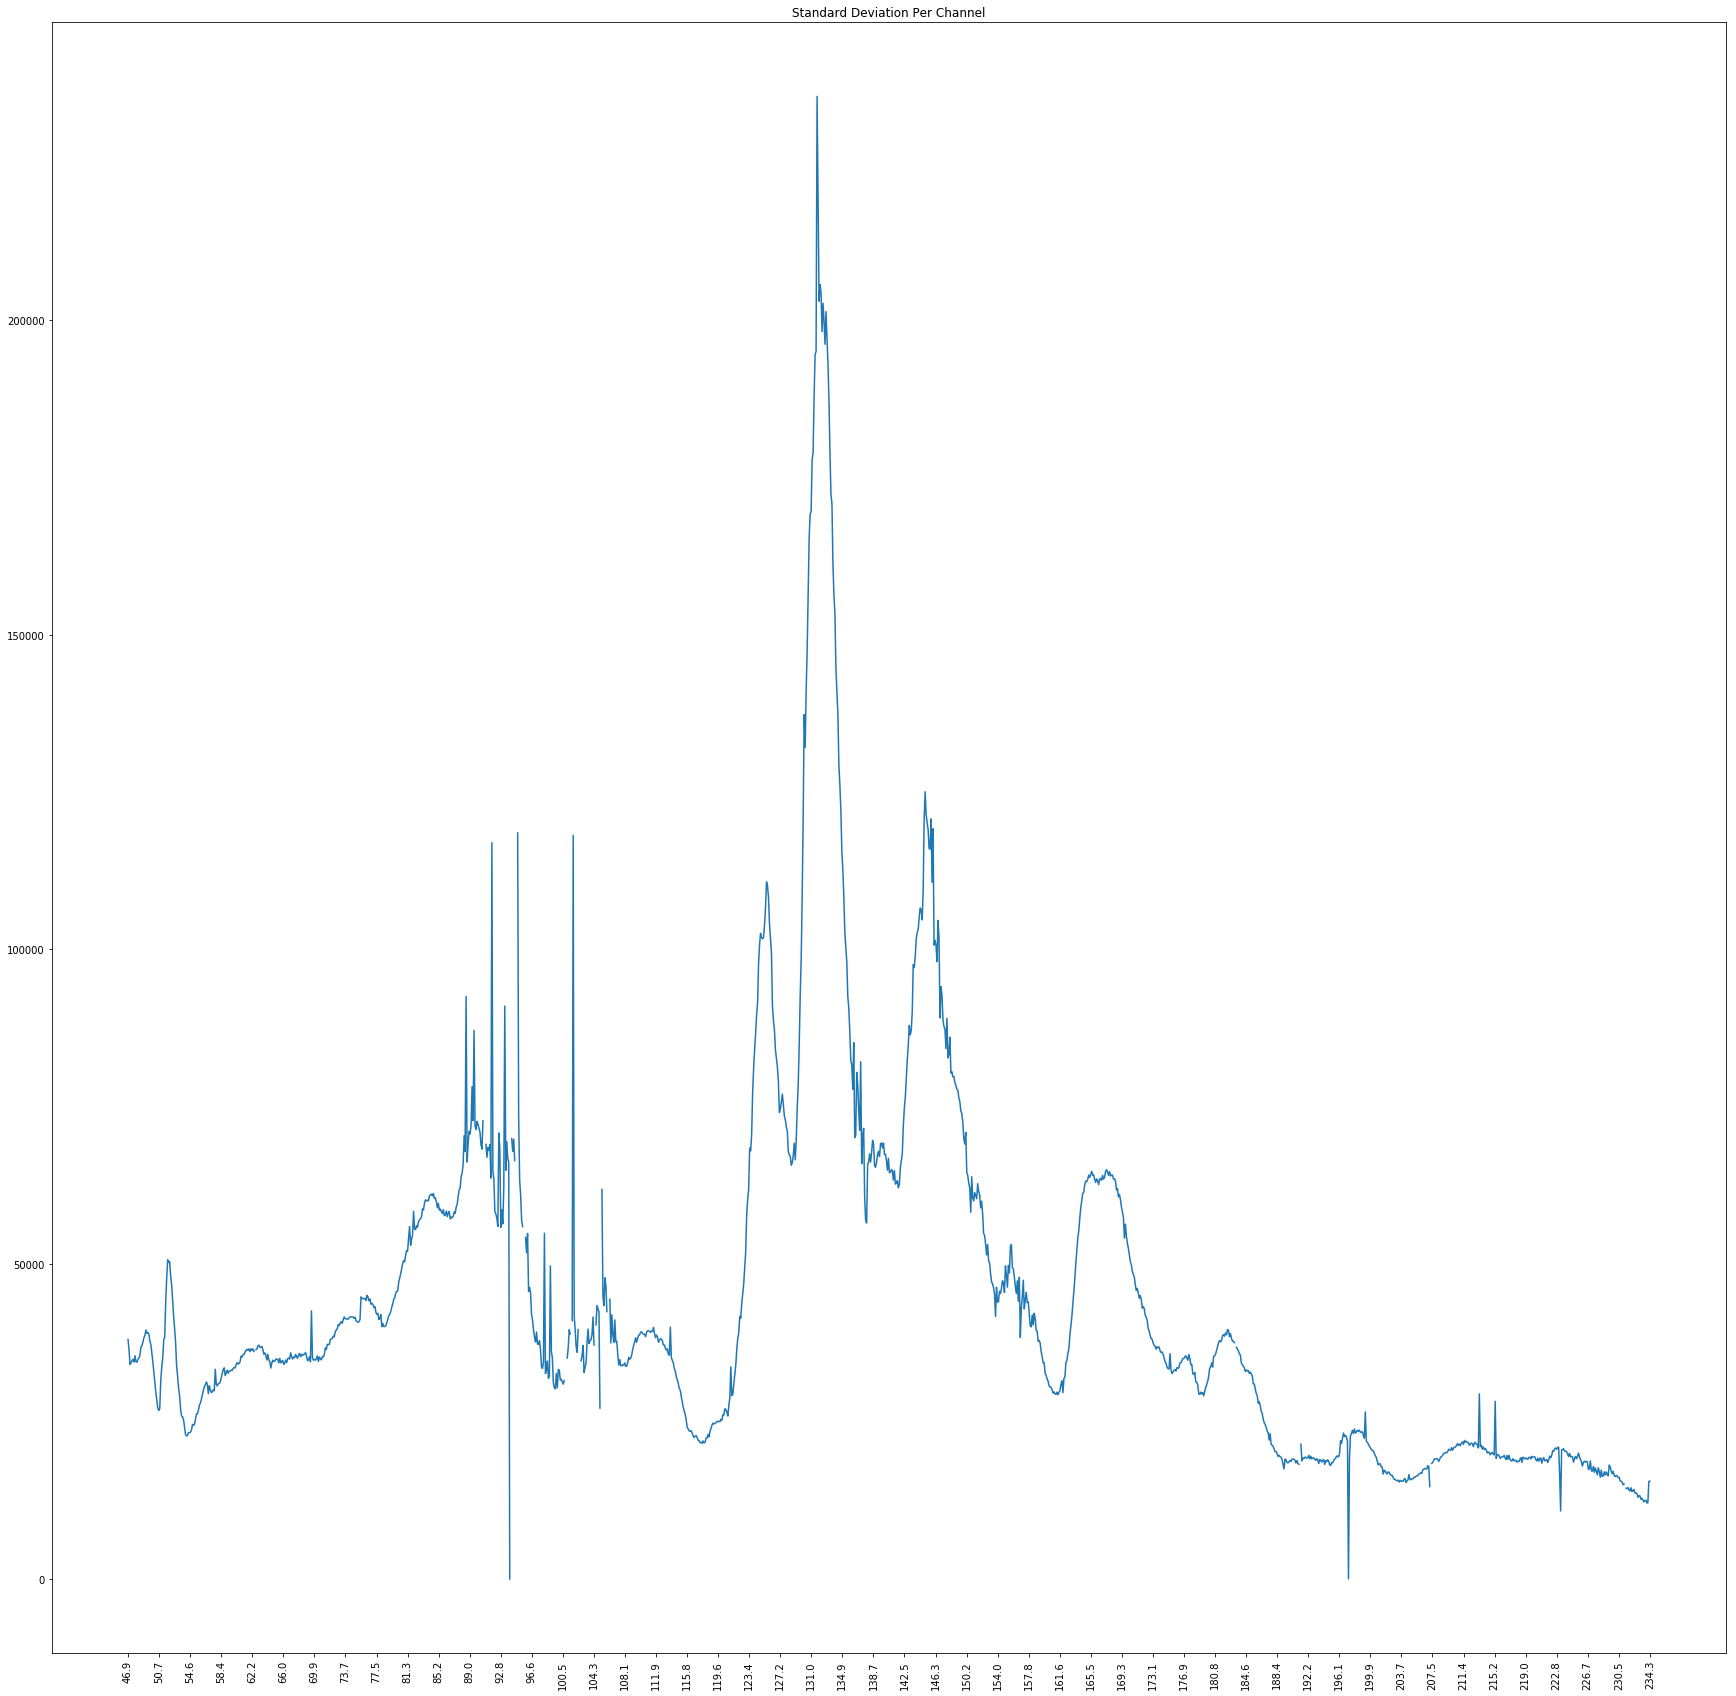

In [6]:
figx=30;figy=30; 
xticks=np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(np.array(uvd.freq_array[0]/1.e6)[1:]),50);


max_preXRFI = np.max(powers_per_time,axis=0)
mean = np.mean(powers_per_time_XRFI,axis=0)
arr_max = np.max(powers_per_time_XRFI,axis=0)
arr_min = np.min(powers_per_time_XRFI,axis=0)

plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6), mean,'k-',label='Mean')
#plt.plot( np.array(uvd.freq_array[0]/1.e6), max_preXRFI,'g-',label='Raw Max, before XRFI')
plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_max,'r-',label='Max')
plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_min,'b-',label='Min')
plt.title('Mean, Min, and Max of post-XRFI data')
plt.legend()
plt.xticks(xticks,rotation='vertical')

ratio_mean = np.divide(mean[1:], mean[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_mean)
plt.title('Ratio of Means (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')


plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(ratio_mean-1.))
plt.title('log(Ratio of Means -1.) (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')

median = np.median(powers_per_time_XRFI,axis=0)
ratio_median = np.divide(median[1:], median[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_median)
plt.title('Ratio of Medians (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')

plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(ratio_median-1.))
plt.title('log(Ratio of Medians -1.) (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')


std = np.std(powers_per_time_XRFI,axis=0)
ratio_std = np.divide(std[1:], std[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_std)
plt.title('Ratio of Standard Deviations (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')

plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(ratio_std-1.))
plt.title('log(Ratio of Standard Deviations -1.) (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')


std = np.std(powers_per_time_XRFI,axis=0)
ratio_std = np.divide(std[1:], std[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( uvd.freq_array[0]/1.e6, std)
plt.title('Standard Deviation Per Channel')
plt.xticks(xticks,rotation='vertical')
